## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

D:\Users\ryanl\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [76]:
import tensorflow as tf
import keras.backend as K

"""
TO DO:
Write your combined loss
"""

def focal_loss_fixed(y_true, y_pred, gamma=2., alpha=4.):
    """Focal loss for multi-classification
    FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
    """
    epsilon = 1e-8
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), float(gamma)))
    fl = tf.multiply(float(alpha), tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    return tf.reduce_mean(reduced_fl)

def combined_loss(y_true, y_pred):
    """Define the customized loss."""
    return 0.3*focal_loss_fixed(y_true, y_pred)+0.7*keras.losses.categorical_crossentropy(y_true, y_pred)

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [77]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss, metrics=["accuracy"], optimizer=optimizer)
    
    """
    TO DO:
    Compile your model with customized loss
    """

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_118 (Bat (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_119 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_120 (Bat (None, 128) 

50000/50000 [==============================] - 10s 190us/step - loss: 1.6142 - acc: 0.6163 - val_loss: 2.1737 - val_acc: 0.4934
Epoch 14/25
50000/50000 [==============================] - 9s 182us/step - loss: 1.5637 - acc: 0.6271 - val_loss: 2.1872 - val_acc: 0.4937
Epoch 15/25
50000/50000 [==============================] - 10s 195us/step - loss: 1.5152 - acc: 0.6384 - val_loss: 2.2057 - val_acc: 0.4961
Epoch 16/25
50000/50000 [==============================] - 10s 195us/step - loss: 1.4634 - acc: 0.6490 - val_loss: 2.2102 - val_acc: 0.4921
Epoch 17/25
50000/50000 [==============================] - 9s 182us/step - loss: 1.4127 - acc: 0.6614 - val_loss: 2.2023 - val_acc: 0.5030
Epoch 18/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.3705 - acc: 0.6721 - val_loss: 2.2229 - val_acc: 0.4924
Epoch 19/25
50000/50000 [==============================] - 9s 179us/step - loss: 1.3220 - acc: 0.6820 - val_loss: 2.2330 - val_acc: 0.5018
Epoch 20/25
50000/50000 [===========

50000/50000 [==============================] - 11s 229us/step - loss: 3.4480 - acc: 0.3018 - val_loss: 3.6894 - val_acc: 0.1547
Epoch 2/25
50000/50000 [==============================] - 9s 182us/step - loss: 2.5641 - acc: 0.4212 - val_loss: 3.0763 - val_acc: 0.3000
Epoch 3/25
50000/50000 [==============================] - 9s 183us/step - loss: 2.3565 - acc: 0.4601 - val_loss: 2.7526 - val_acc: 0.3896
Epoch 4/25
50000/50000 [==============================] - 10s 210us/step - loss: 2.2226 - acc: 0.4885 - val_loss: 2.5290 - val_acc: 0.4314
Epoch 5/25
50000/50000 [==============================] - 12s 247us/step - loss: 2.1239 - acc: 0.5037 - val_loss: 2.4205 - val_acc: 0.4445
Epoch 6/25
50000/50000 [==============================] - 11s 217us/step - loss: 2.0397 - acc: 0.5241 - val_loss: 2.3396 - val_acc: 0.4577
Epoch 7/25
50000/50000 [==============================] - 9s 182us/step - loss: 1.9661 - acc: 0.5373 - val_loss: 2.2699 - val_acc: 0.4690
Epoch 8/25
50000/50000 [=================

50000/50000 [==============================] - 12s 250us/step - loss: 1.0782 - acc: 0.7434 - val_loss: 2.3378 - val_acc: 0.4860
Epoch 25/25
50000/50000 [==============================] - 11s 216us/step - loss: 1.0331 - acc: 0.7556 - val_loss: 2.3630 - val_acc: 0.4899


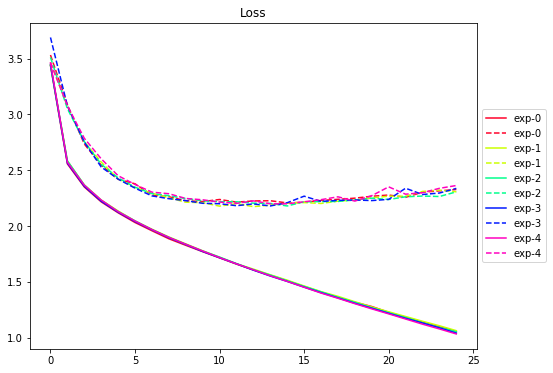

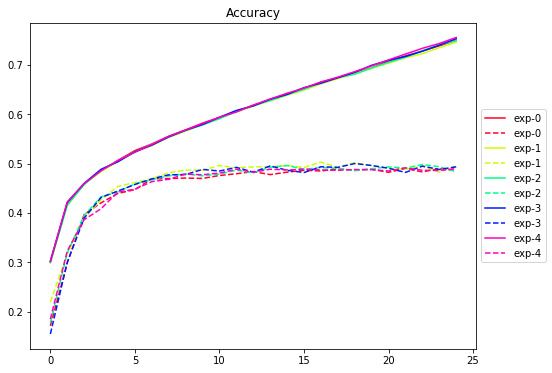

In [78]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()